#### OBJETIVO: Analisis de los mapas de PM2.5 generados con/sin AOD

In [2]:
#Librerias
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import numpy as np
from rasterio.warp import reproject, Resampling
import geopandas as gpd
from matplotlib.colors import TwoSlopeNorm
print("Librerias ok")


Librerias ok


In [ ]:
#Lo hacemos asi porque todos son distintos entonces lo ponemos una vez y ya esta
STATIONS = {
    "SP": {
            "colors": {
            "AOD": "#a1d99b",
            "sAOD": "#41ab5d",
        }
    },
    "CH": {
        
        "colors": {
            
            "AOD": "#feb24c",
            "sAOD": "#fc4e2a",
        }
    },
    "BA": {
        
        "colors": {
            
            "AOD": "#fb6a4a",
            "sAOD": "#99000d",
        }
    },
    "MD": {
        
        "colors": {
            
            "AOD": "#9ecae1",
            "sAOD": "#2171b5",
        }
    },
    "MX": {
        
        "colors": {
           
            "AOD": "#807dba",
            "sAOD": "#810f7c",
        }
    },
}



'#fb6a4a'

In [3]:
#Funcion para alinear ambos raster de las predicciones con/sin AOD
#Se le coloca misma proyeccion, si es nesario se resambplean?
def load_and_align_rasters(path_AOD, path_sAOD):
    with rasterio.open(path_AOD) as src_aod:
        aod = src_aod.read(1)
        profile = src_aod.profile

    with rasterio.open(path_sAOD) as src_saod:
        saod = src_saod.read(1)

        saod_resampled = np.empty_like(aod)
        reproject(
            source=saod,
            destination=saod_resampled,
            src_transform=src_saod.transform,
            src_crs=src_saod.crs,
            dst_transform=profile["transform"],
            dst_crs=profile["crs"],
            resampling=Resampling.bilinear
        )

    return aod, saod_resampled, profile


In [5]:
# Funcion para calcular algunas metricas basicas en los rasters a partir de los valores
#El raster notiene ninguna otra capa/sds solo la de los valores
def raster_stats(arr):
    vals = arr[~np.isnan(arr)]
    return {
        "mean": np.mean(vals),
        "sd": np.std(vals),
        "min": np.min(vals),
        "max": np.max(vals)
    }


In [6]:
#Funcion para ahcer el plot de los histogramas
def plot_histograms(aod, saod, color_aod, color_saod, xlim):
    aod_v = aod[~np.isnan(aod)] # Solo me quedoo con los valores validos
    saod_v = saod[~np.isnan(saod)]

    fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

    sns.histplot(aod_v, bins=20, ax=axes[0],
                 color=color_aod, edgecolor="black")
    sns.histplot(saod_v, bins=20, ax=axes[1],
                 color=color_saod, edgecolor="black")

    for ax in axes:
        ax.set_xlim(xlim)
        ax.set_xlabel("")
        ax.set_ylabel("")
        sns.despine(ax=ax)

    plt.tight_layout()
    plt.show()


In [12]:
#Plot con la diferencia a nivel espacial entre ambos modelos

#Diferencia absoluta
def plot_difference_map(diff, profile, sitio):#, shp_path):
    #gdf = gpd.read_file(shp_path).to_crs(profile["crs"])

    vmax = np.nanmax(np.abs(diff))
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)

    fig, ax = plt.subplots(figsize=(5, 5))

    img = ax.imshow(diff, cmap="RdBu_r", norm=norm)
    #gdf.boundary.plot(ax=ax, color="black", linewidth=1)

    ax.set_axis_off()
    cbar = plt.colorbar(img, ax=ax, shrink=0.75)
    cbar.set_label("Δ PM₂.₅ (AOD – sAOD)")
    plt.title (f"Estacion: {sitio}")
    plt.tight_layout()
    plt.show()
#Diferencia relativa en %
def relative_difference(aod, saod):
    return ((aod - saod) / saod) * 100


ESTACION SP
AOD {'mean': np.float32(17.051672), 'sd': np.float32(4.2238984), 'min': np.float32(10.617001), 'max': np.float32(29.12815)}
sAOD {'mean': np.float32(15.654053), 'sd': np.float32(3.0546808), 'min': np.float32(10.606165), 'max': np.float32(23.712454)}


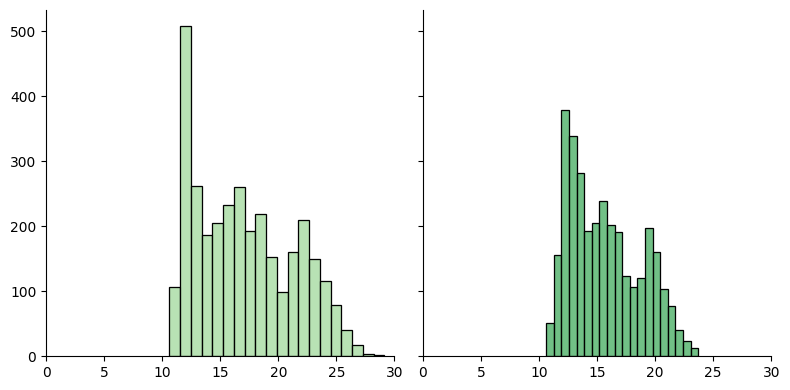

Diferencia absoluta


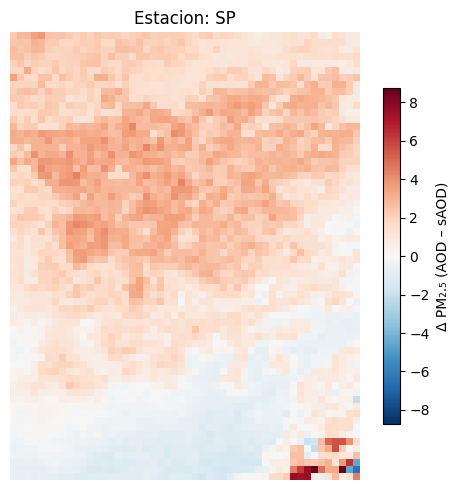

Diferencia relativa


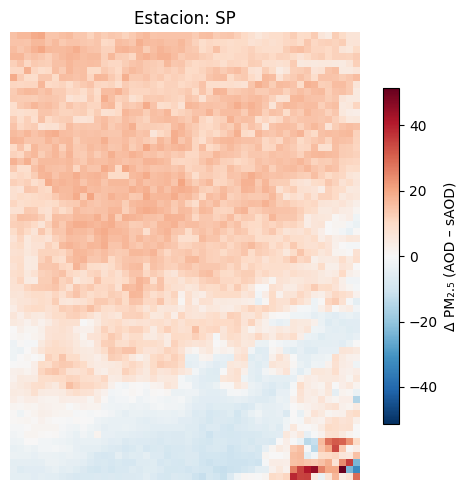

In [17]:
#Corremos los ejemplos para cada centro urbano
aod, saod, profile = load_and_align_rasters(
    "D:/Josefina/Proyectos/ProyectoChile/SP/modelos/salidas/SalidasAnuales/01-XGB-CV-M1-200525-SP/Promedio_anual_2024-01-XGB-CV-M1-200525-SP.tif",
    "D:/Josefina/Proyectos/ProyectoChile/SP/modelos/salidas/SalidasAnuales/02-XGB-CV-1-210525-sAOD-SP/Promedio_anual_2024-02-XGB-CV-1-210525-sAOD-SP.tif"
)

# Estadísticas
stats_AOD = raster_stats(aod)
stats_sAOD = raster_stats(saod)
print("ESTACION SP")
print("AOD",stats_AOD)
print("sAOD",stats_sAOD)
# Histogramas
plot_histograms(
    aod, saod,
    color_aod=STATIONS["SP"]['colors']['AOD'],
    color_saod=STATIONS["SP"]['colors']['sAOD'],
    xlim=(0, 30)
)

# Diferencia absoluta
print("Diferencia absoluta")
diff = aod - saod
plot_difference_map(diff, profile,sitio="SP")#,
    #"D:/Josefina/Proyectos/ProyectoChile/SP/shape/ciudad_SP.shp")
# print()
# Diferencia relativa
print("Diferencia relativa")
diff_rel = relative_difference(aod, saod)
plot_difference_map(diff_rel, profile,sitio="SP")#,
    #"D:/Josefina/Proyectos/ProyectoChile/SP/shape/ciudad_SP.shp")




ESTACION SP
AOD {'mean': np.float32(21.37006), 'sd': np.float32(3.551328), 'min': np.float32(13.880917), 'max': np.float32(28.820026)}
sAOD {'mean': np.float32(22.329048), 'sd': np.float32(3.231142), 'min': np.float32(15.203079), 'max': np.float32(30.549137)}


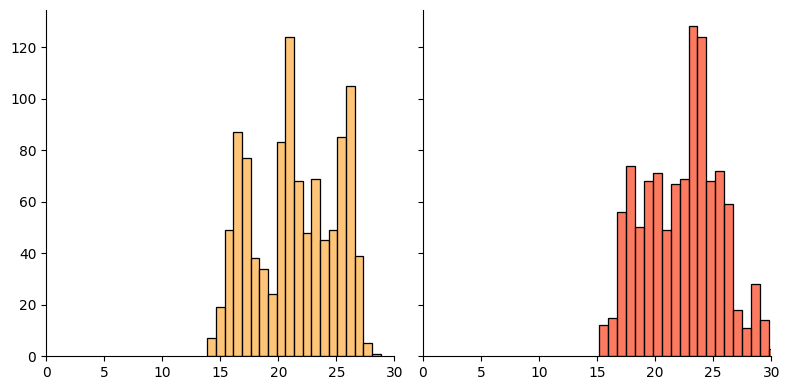

Diferencia absoluta


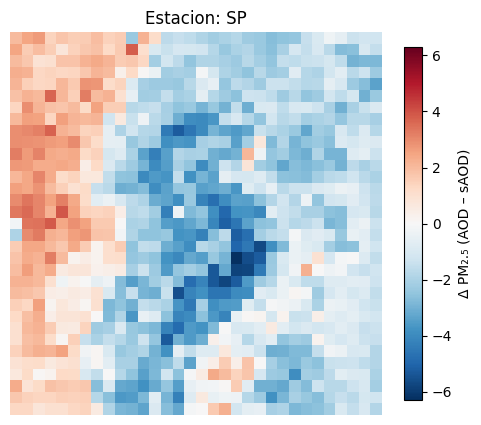

Diferencia relativa


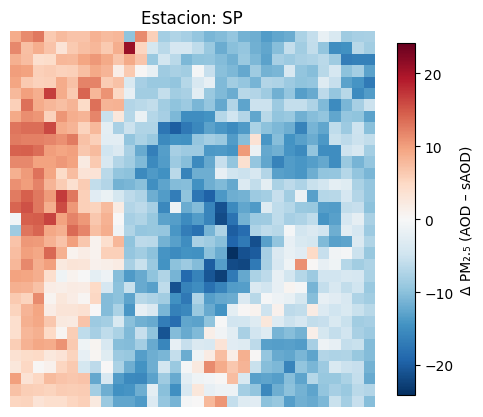

In [18]:
#Corremos los ejemplos para cada centro urbano
aod, saod, profile = load_and_align_rasters(
    "D:/Josefina/Proyectos/ProyectoChile/CH/modelos/salidas/SalidasAnuales/01-XGB-CV-M1-190625-CH/Promedio_anual_2024-01-XGB-CV-M1-190625-CH.tif",
    "D:/Josefina/Proyectos/ProyectoChile/CH/modelos/salidas/SalidasAnuales/02-XGB-CV-M1-230625-sAOD-CH/Promedio_anual_2024-02-XGB-CV-M1-230625-sAOD-CH.tif"
)

# Estadísticas
stats_AOD = raster_stats(aod)
stats_sAOD = raster_stats(saod)
print("ESTACION SP")
print("AOD",stats_AOD)
print("sAOD",stats_sAOD)
# Histogramas
plot_histograms(
    aod, saod,
    color_aod=STATIONS["CH"]['colors']['AOD'],
    color_saod=STATIONS["CH"]['colors']['sAOD'],
    xlim=(0, 30)
)

# Diferencia absoluta
print("Diferencia absoluta")
diff = aod - saod
plot_difference_map(diff, profile,sitio="SP")#,
    #"D:/Josefina/Proyectos/ProyectoChile/SP/shape/ciudad_SP.shp")
# print()
# Diferencia relativa
print("Diferencia relativa")
diff_rel = relative_difference(aod, saod)
plot_difference_map(diff_rel, profile,sitio="SP")#,
    #"D:/Josefina/Proyectos/ProyectoChile/SP/shape/ciudad_SP.shp")



d:\Josefina\Proyectos\Tesis\code\.venv\Lib\site-packages\numpy\_core\_methods.py:134: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
d:\Josefina\Proyectos\Tesis\code\.venv\Lib\site-packages\numpy\_core\_methods.py:170: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


ESTACION BA
AOD {'mean': np.float32(16.773281), 'sd': np.float32(1.8901541), 'min': np.float32(13.098204), 'max': np.float32(22.874918)}
sAOD {'mean': np.float32(-inf), 'sd': np.float32(inf), 'min': np.float32(-3.4e+38), 'max': np.float32(23.047565)}


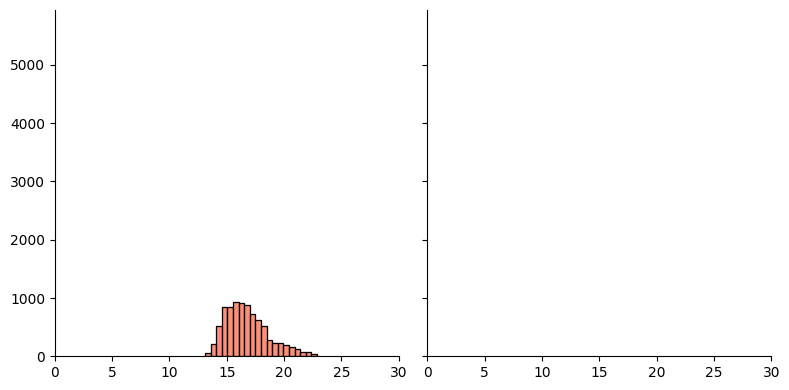

Diferencia absoluta


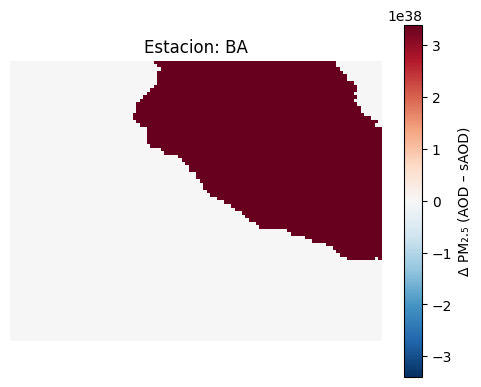

Diferencia relativa


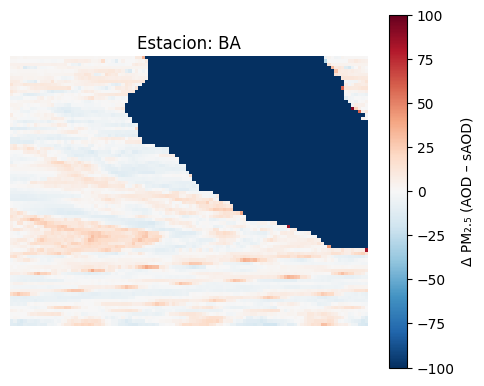

In [20]:
#Corremos los ejemplos para cada centro urbano
aod, saod, profile = load_and_align_rasters(
    "D:/Josefina/Proyectos/ProyectoChile/BA/modelos/salidas/SalidasAnuales/01-ET-CV-M1-170625-BA/Promedio_anual_2024-01-ET-CV-M1-170625-BA.tif",
    "D:/Josefina/Proyectos/ProyectoChile/BA/modelos/salidas/SalidasAnuales/02-ET-CV-M1-230625-sAOD-BA/Promedio_anual_2024-02-ET-CV-M1-230625-sAOD-BA.tif"
)

# Estadísticas
stats_AOD = raster_stats(aod)
stats_sAOD = raster_stats(saod)
print("ESTACION BA")
print("AOD",stats_AOD)
print("sAOD",stats_sAOD)
# Histogramas
plot_histograms(
    aod, saod,
    color_aod=STATIONS["BA"]['colors']['AOD'],
    color_saod=STATIONS["BA"]['colors']['sAOD'],
    xlim=(0, 30)
)

# Diferencia absoluta
print("Diferencia absoluta")
diff = aod - saod
plot_difference_map(diff, profile,sitio="BA")#,
    #"D:/Josefina/Proyectos/ProyectoChile/SP/shape/ciudad_SP.shp")
# print()
# Diferencia relativa
print("Diferencia relativa")
diff_rel = relative_difference(aod, saod)
plot_difference_map(diff_rel, profile,sitio="BA")#,
    #"D:/Josefina/Proyectos/ProyectoChile/SP/shape/ciudad_SP.shp")



ESTACION MD
AOD {'mean': np.float32(15.506046), 'sd': np.float32(3.6044803), 'min': np.float32(10.682694), 'max': np.float32(26.811325)}
sAOD {'mean': np.float32(14.864488), 'sd': np.float32(4.0757494), 'min': np.float32(9.43927), 'max': np.float32(27.59171)}


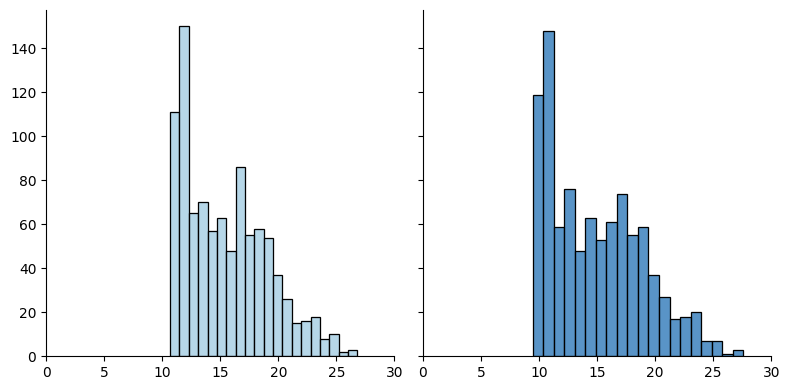

Diferencia absoluta


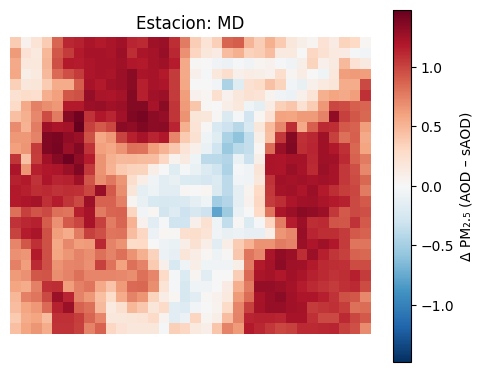

Diferencia relativa


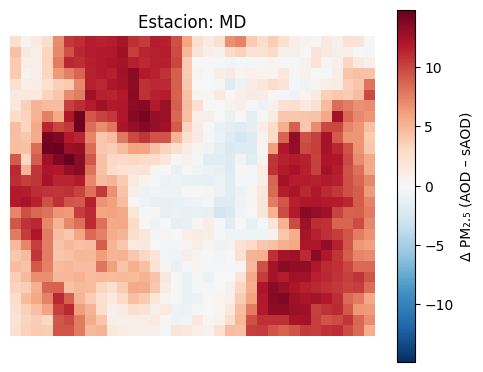

In [21]:
#Corremos los ejemplos para cada centro urbano
aod, saod, profile = load_and_align_rasters(
    "D:/Josefina/Proyectos/ProyectoChile/MD/modelos/salidas/SalidasAnuales/01-ET-CV-M1-260525-MD/Promedio_anual_2024-01-ET-CV-M1-260525-MD.tif",
    "D:/Josefina/Proyectos/ProyectoChile/MD/modelos/salidas/SalidasAnuales/01-ET-CV-M1-270525-sAOD-MD/Promedio_anual_2024-01-ET-CV-M1-270525-sAOD-MD.tif"
)

# Estadísticas
stats_AOD = raster_stats(aod)
stats_sAOD = raster_stats(saod)
print("ESTACION MD")
print("AOD",stats_AOD)
print("sAOD",stats_sAOD)
# Histogramas
plot_histograms(
    aod, saod,
    color_aod=STATIONS["MD"]['colors']['AOD'],
    color_saod=STATIONS["MD"]['colors']['sAOD'],
    xlim=(0, 30)
)

# Diferencia absoluta
print("Diferencia absoluta")
diff = aod - saod
plot_difference_map(diff, profile,sitio="MD")#,
    #"D:/Josefina/Proyectos/ProyectoChile/SP/shape/ciudad_SP.shp")
# print()
# Diferencia relativa
print("Diferencia relativa")
diff_rel = relative_difference(aod, saod)
plot_difference_map(diff_rel, profile,sitio="MD")#,
    #"D:/Josefina/Proyectos/ProyectoChile/SP/shape/ciudad_SP.shp")



ESTACION MX
AOD {'mean': np.float32(20.801107), 'sd': np.float32(3.4088502), 'min': np.float32(14.159309), 'max': np.float32(31.514572)}
sAOD {'mean': np.float32(20.235731), 'sd': np.float32(2.9097435), 'min': np.float32(14.842888), 'max': np.float32(30.189306)}


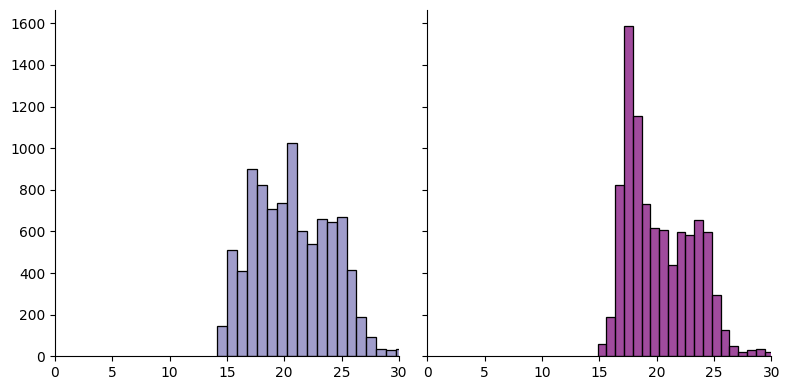

Diferencia absoluta


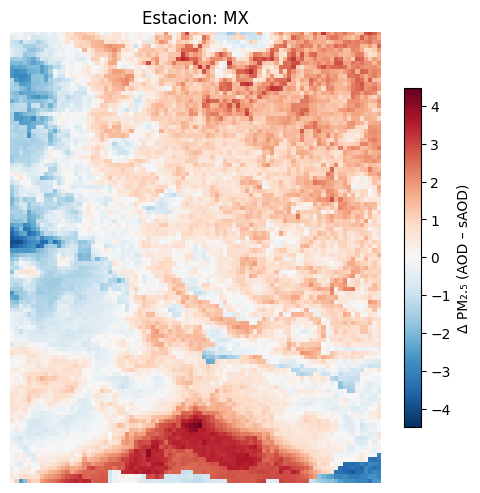

Diferencia relativa


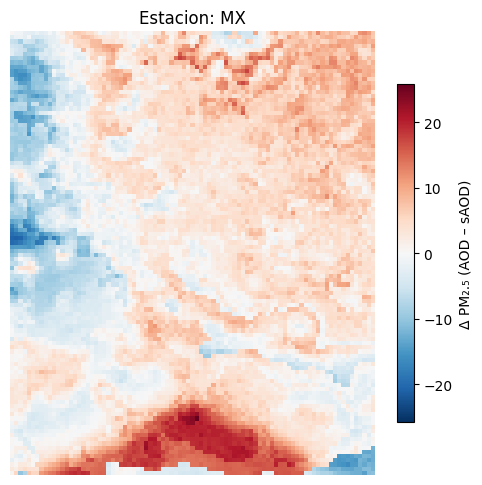

In [22]:
#Corremos los ejemplos para cada centro urbano
aod, saod, profile = load_and_align_rasters(
    "D:/Josefina/Proyectos/ProyectoChile/MX/modelos/salidas/SalidasAnuales/01-XGB-CV-M1-290525-MX/Promedio_anual_2024-01-XGB-CV-M1-290525-MX.tif",
    "D:/Josefina/Proyectos/ProyectoChile/MX/modelos/salidas/SalidasAnuales/02-XGB-CV-M1-230625-sAOD-MX/Promedio_anual_2024-02-XGB-CV-M1-230625-sAOD-MX.tif"
)

# Estadísticas
stats_AOD = raster_stats(aod)
stats_sAOD = raster_stats(saod)
print("ESTACION MX")
print("AOD",stats_AOD)
print("sAOD",stats_sAOD)
# Histogramas
plot_histograms(
    aod, saod,
    color_aod=STATIONS["MX"]['colors']['AOD'],
    color_saod=STATIONS["MX"]['colors']['sAOD'],
    xlim=(0, 30)
)

# Diferencia absoluta
print("Diferencia absoluta")
diff = aod - saod
plot_difference_map(diff, profile,sitio="MX")#,
    #"D:/Josefina/Proyectos/ProyectoChile/SP/shape/ciudad_SP.shp")
# print()
# Diferencia relativa
print("Diferencia relativa")
diff_rel = relative_difference(aod, saod)
plot_difference_map(diff_rel, profile,sitio="MX")#,
    #"D:/Josefina/Proyectos/ProyectoChile/SP/shape/ciudad_SP.shp")

